# Generative AI for Image Generation

## Introduction

This notebook demonstrates the application of generative AI techniques for image generation using two different datasets. We implement two different generative models—VAEs (Variational Autoencoders) and GANs (Generative Adversarial Networks)—to generate realistic images, compare their performance, and explore how different data characteristics affect model behavior.

# Setup and Dependencies

In [ ]:
# prompt: install tensorflow

!pip install tensorflow
!pip install

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 789.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import glob
import random
from tqdm import tqdm
from IPython.display import display, Image

ModuleNotFoundError: No module named 'pretty_midi'


# First Worked Example: Variational Autoencoder (VAE) on CIFAR-10

## 1. Data Acquisition and Exploration

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.


Training data shape: (50000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)


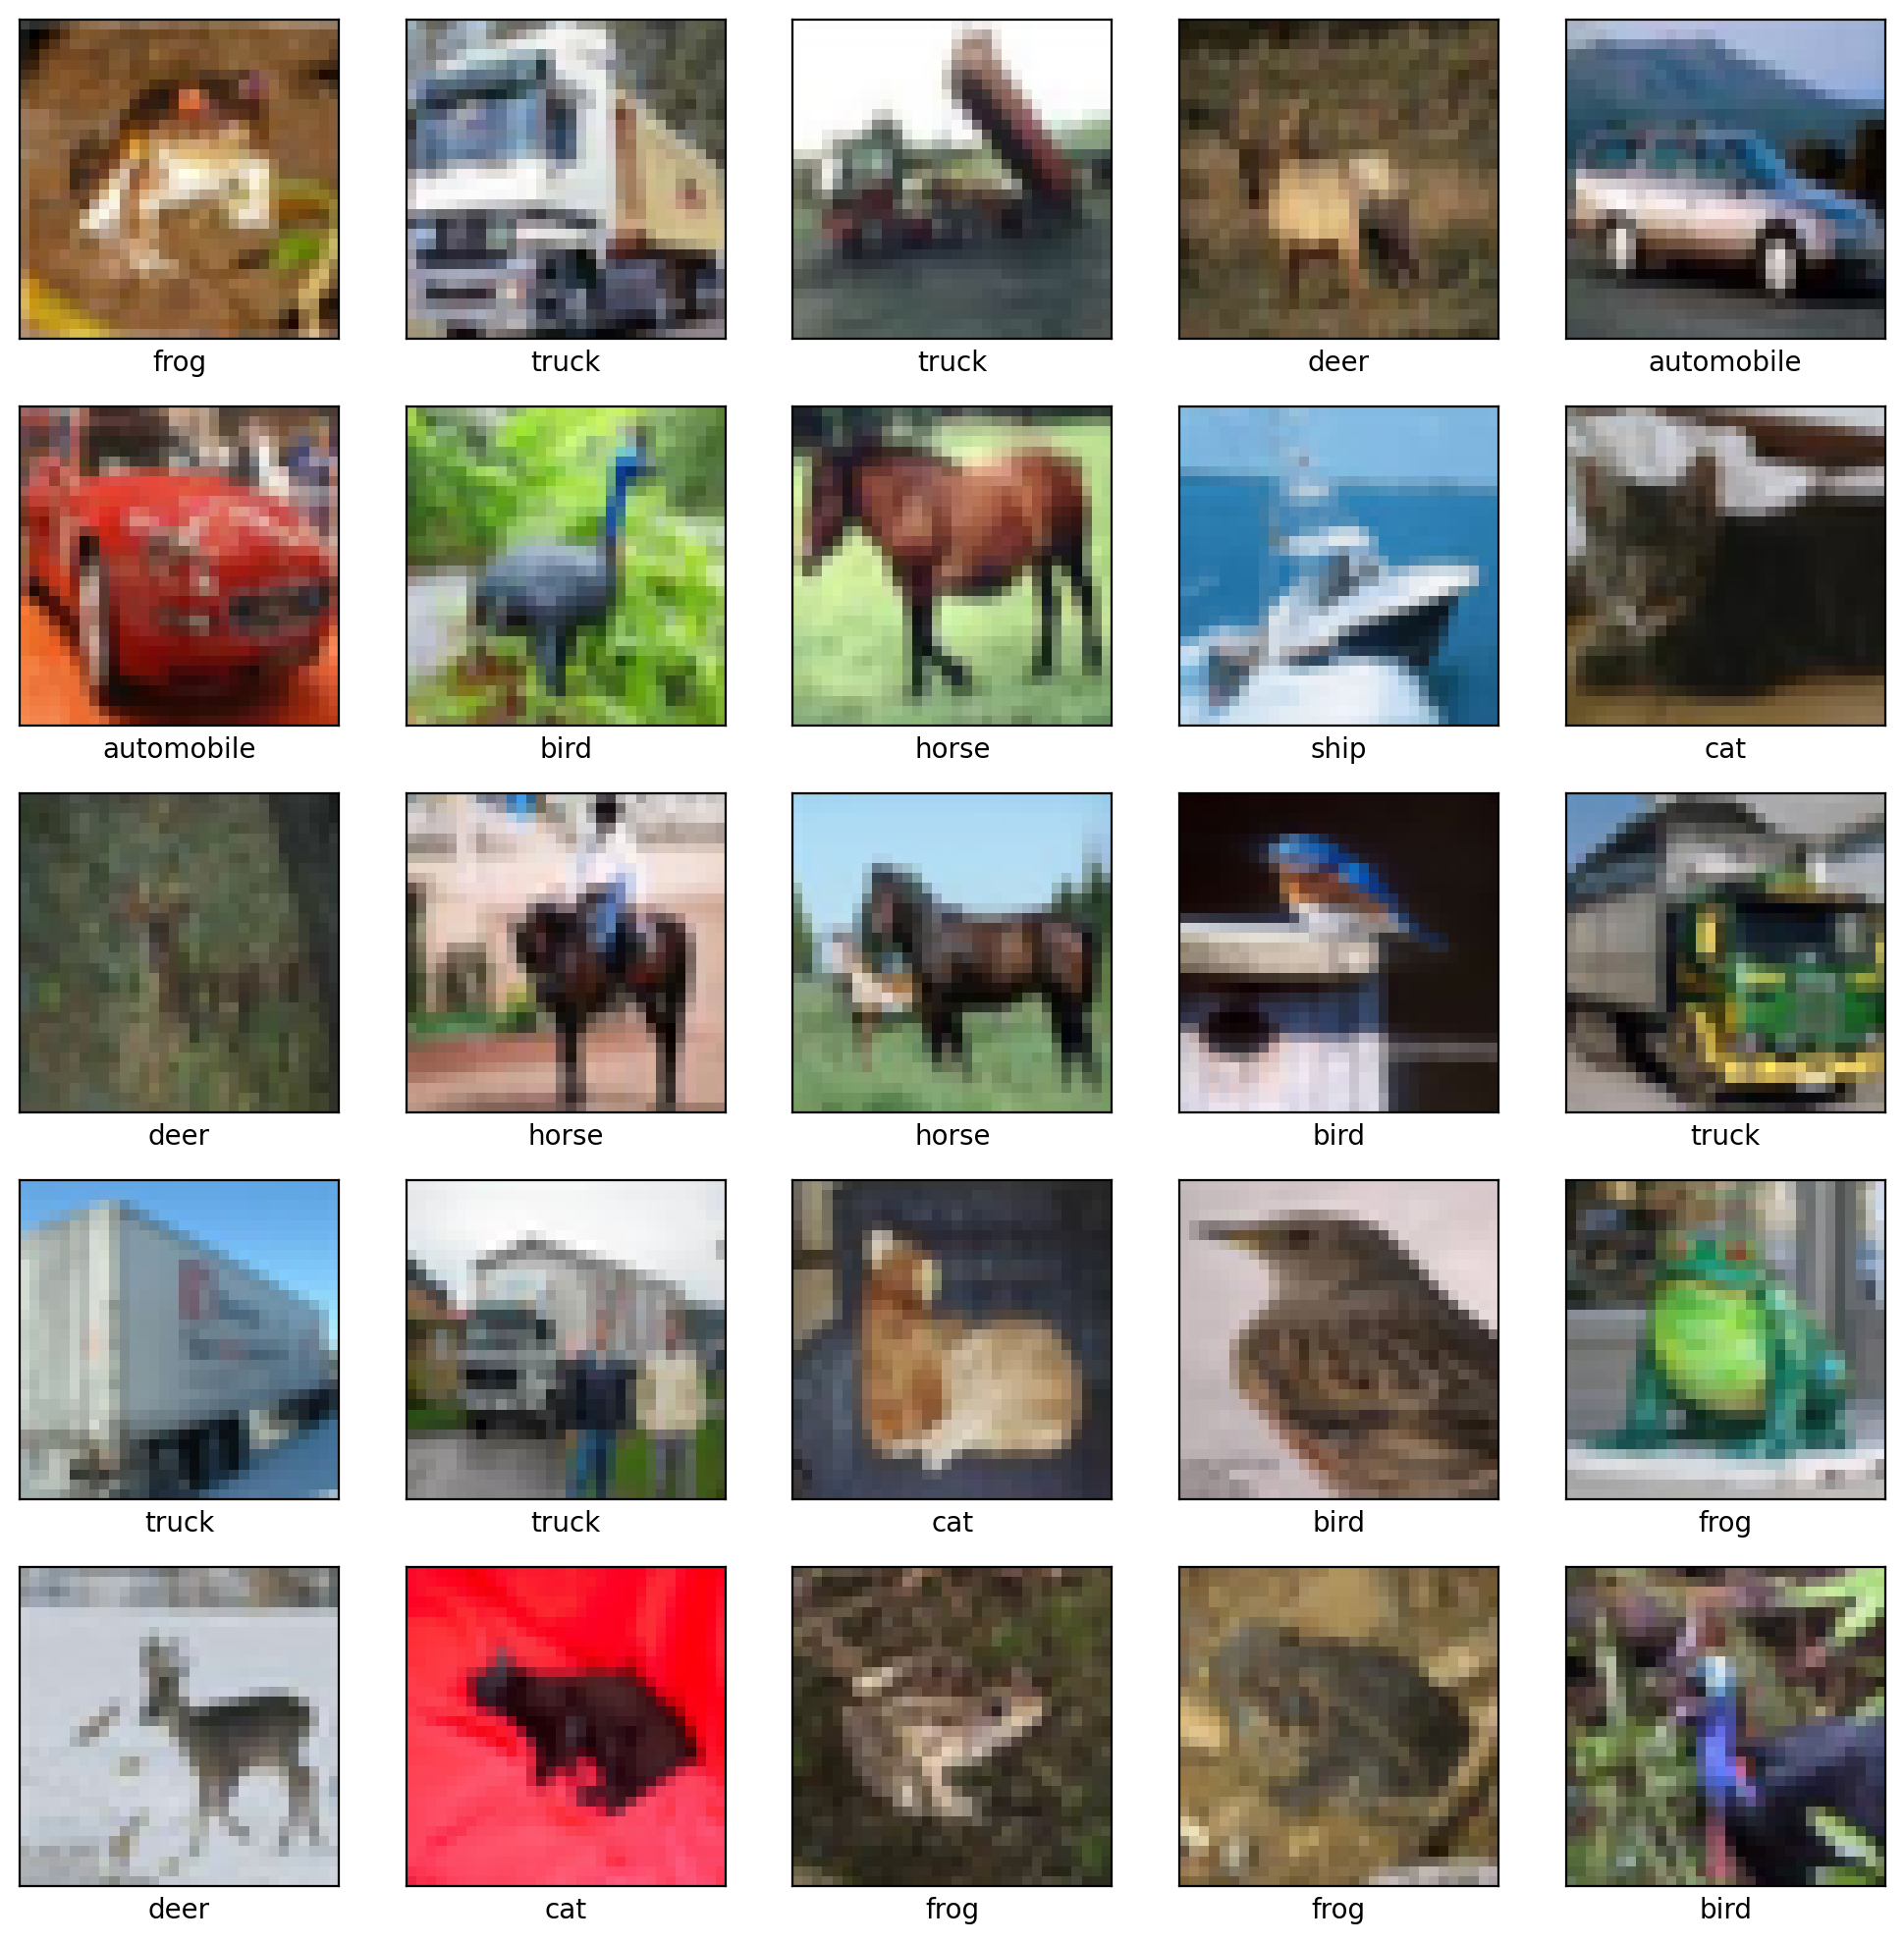

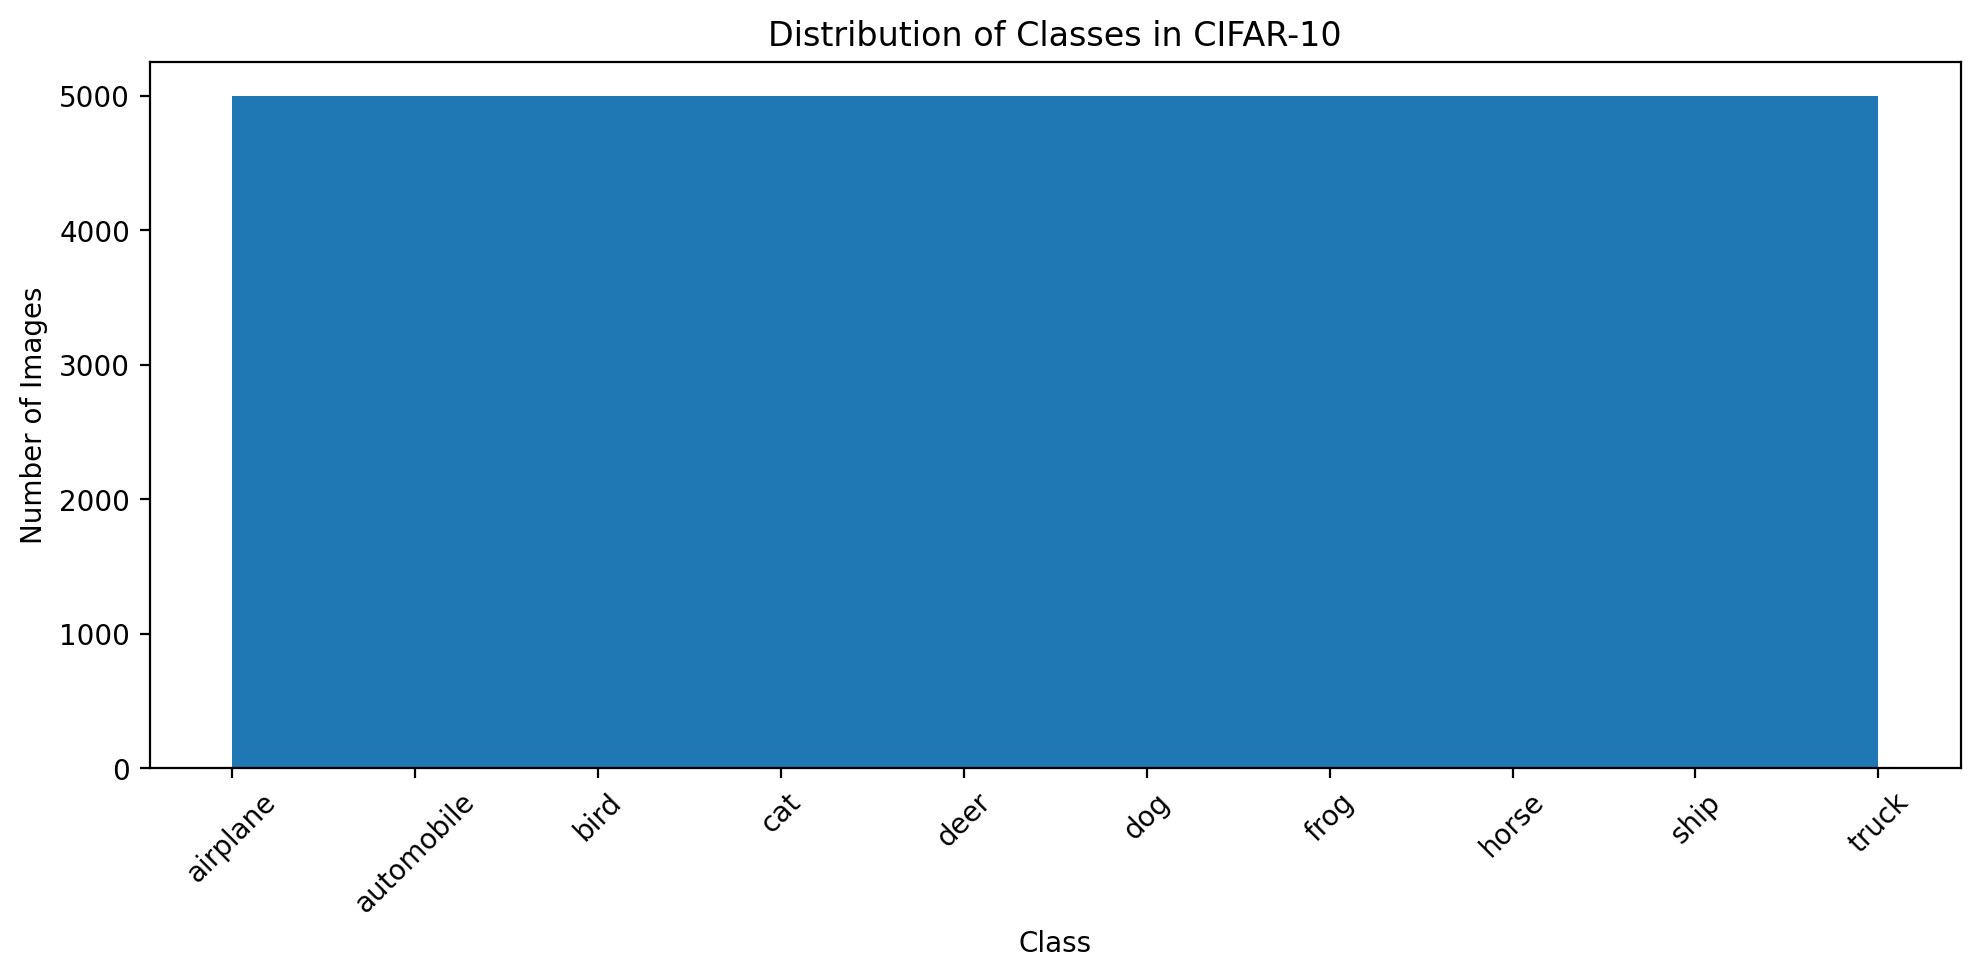

In [ ]:

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Print dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Display sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.tight_layout()
plt.show()

# Plot distribution of classes
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=10)
plt.title('Distribution of Classes in CIFAR-10')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(range(10), class_names, rotation=45)
plt.tight_layout()
plt.show()


## 2. Variational Autoencoder (VAE) Architecture

VAEs are generative models that learn to encode input data into a latent space and then decode samples from this space back into the original data space. The key insight in VAEs is that the latent space is probabilistic, allowing for generation of new samples.


In [ ]:
# Define the VAE model
class CIFAR10VAE(keras.Model):
    def __init__(self, latent_dim=128, **kwargs):
        super(CIFAR10VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = keras.Sequential([
            layers.Input(shape=(32, 32, 3)),
            layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(128, 3, strides=2, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(latent_dim + latent_dim)  # Mean and log-variance
        ])

        # Decoder
        self.decoder = keras.Sequential([
            layers.Input(shape=(latent_dim,)),
            layers.Dense(4 * 4 * 128, activation='relu'),
            layers.Reshape((4, 4, 128)),
            layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(3, 3, padding='same', activation='sigmoid')
        ])

    def encode(self, x):
        mean_logvar = self.encoder(x)
        mean, logvar = tf.split(mean_logvar, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z):
        return self.decoder(z)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mean, logvar

# VAE Loss function
def vae_loss(inputs, reconstructed, mean, logvar):
    # Flatten input and reconstructed images
    inputs_flat = tf.reshape(inputs, [-1, 32*32*3])
    reconstructed_flat = tf.reshape(reconstructed, [-1, 32*32*3])

    # Reconstruction loss (pixel-wise MSE)
    reconstruction_loss = tf.reduce_mean(tf.square(inputs_flat - reconstructed_flat))
    reconstruction_loss *= 32 * 32 * 3  # Scale by image dimensions

    # KL divergence
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))

    # Total loss
    total_loss = reconstruction_loss + kl_loss
    return total_loss


## 3. Model Training

Epoch 1/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 190s 476ms/step
Average loss: 83.7548
Epoch 2/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 187s 477ms/step
Average loss: 38.3533
Epoch 3/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 188s 478ms/step
Average loss: 30.5249
Epoch 4/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 186s 473ms/step
Average loss: 26.6741
Epoch 5/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 190s 484ms/step
Average loss: 23.7542


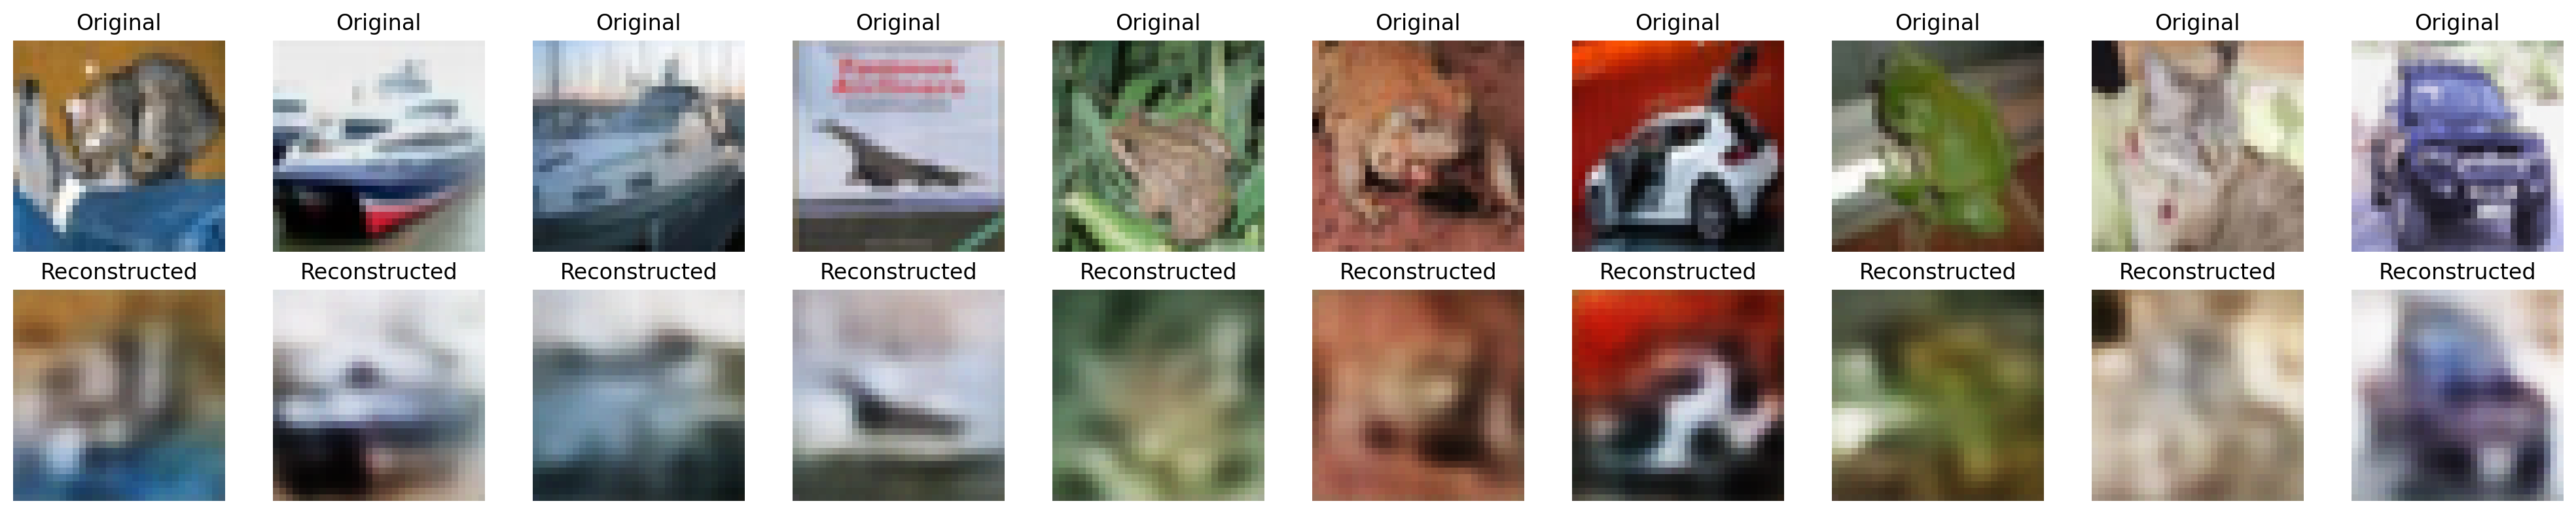

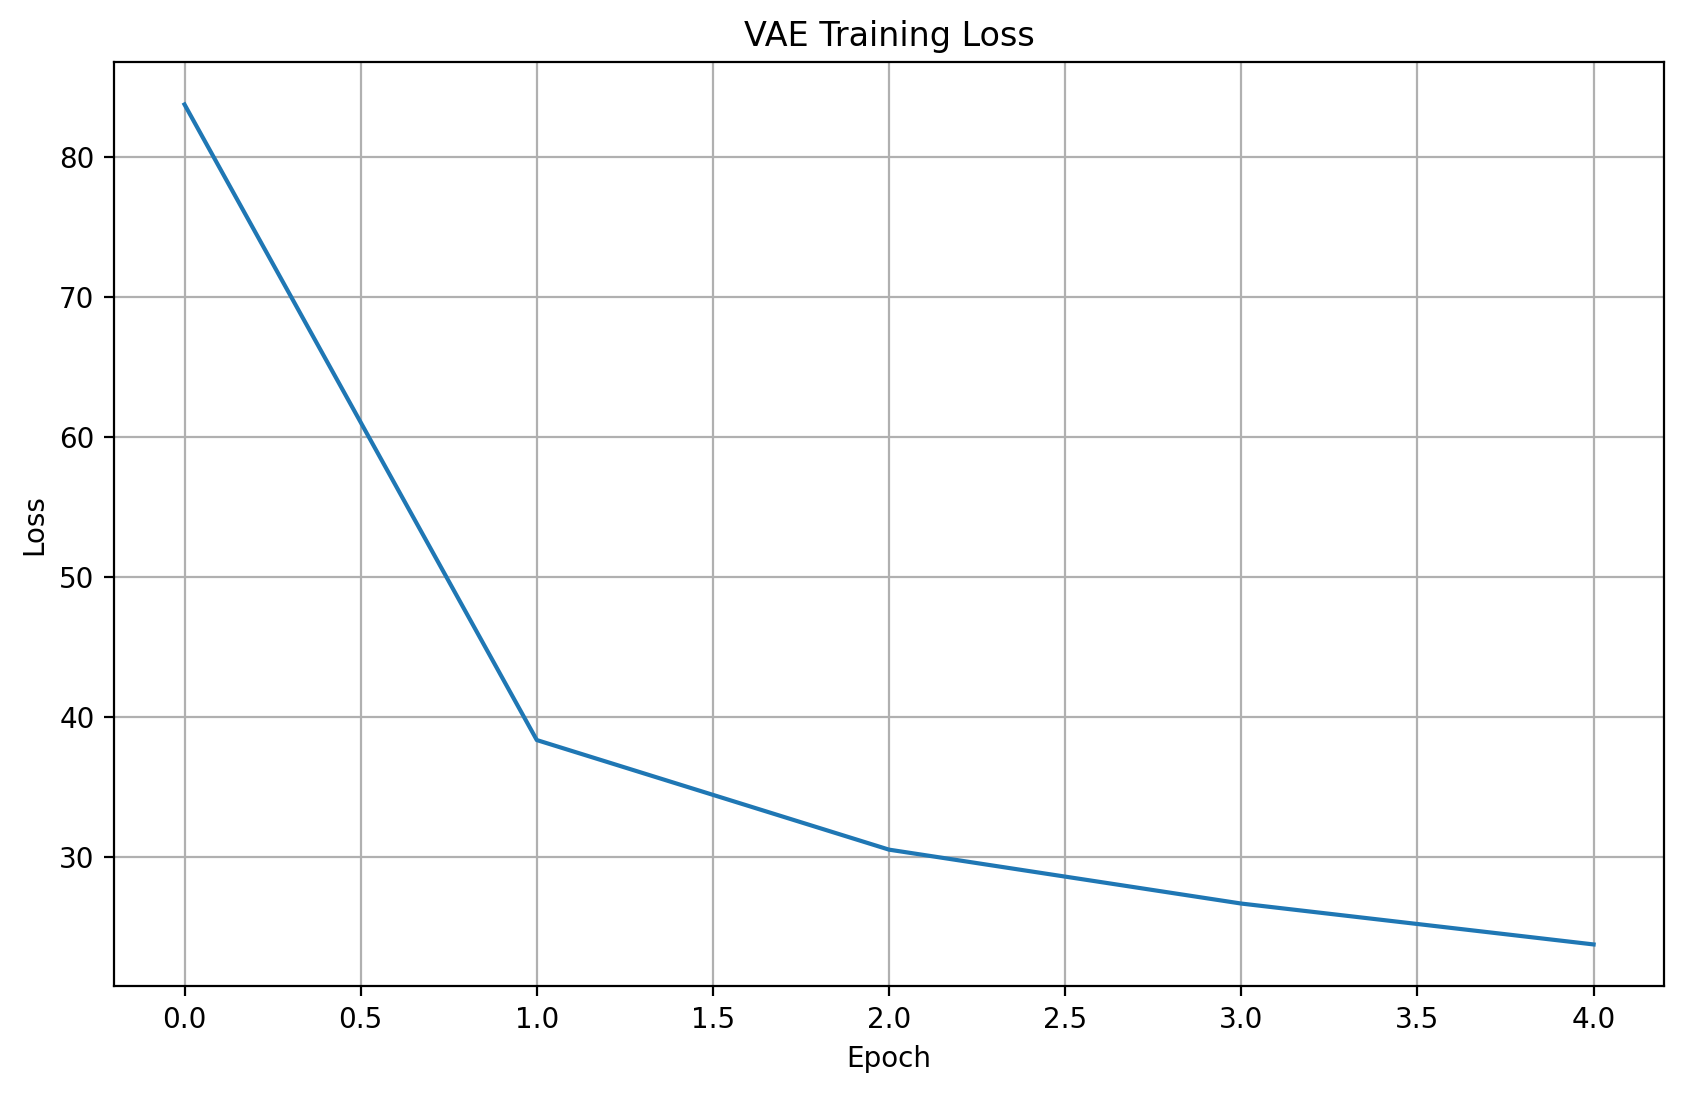

In [ ]:
# Initialize VAE model
latent_dim = 128
vae = CIFAR10VAE(latent_dim=latent_dim)

# Compile the model with the custom loss function
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# Train the model using custom training loop
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        reconstructed, mean, logvar = vae(batch)
        loss = vae_loss(batch, reconstructed, mean, logvar)

    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

# Training parameters
batch_size = 128
epochs = 5
steps_per_epoch = len(x_train) // batch_size

# Training loop
loss_history = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    progbar = tf.keras.utils.Progbar(steps_per_epoch)

    # Shuffle data for each epoch
    indices = tf.random.shuffle(tf.range(len(x_train)))
    x_shuffled = tf.gather(x_train, indices)

    total_loss = 0
    for step in range(steps_per_epoch):
        batch = x_shuffled[step*batch_size:(step+1)*batch_size]
        loss = train_step(batch)
        total_loss += loss
        progbar.update(step + 1)

    avg_loss = total_loss / steps_per_epoch
    loss_history.append(avg_loss)
    print(f"Average loss: {avg_loss:.4f}")

    # Generate and display some reconstructions every 5 epochs
    if (epoch + 1) % 5 == 0:
        n = 10
        test_samples = x_test[:n]
        reconstructed, _, _ = vae(test_samples)

        plt.figure(figsize=(20, 4))
        for i in range(n):
            # Display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(test_samples[i])
            plt.title("Original")
            plt.axis("off")

            # Display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(reconstructed[i])
            plt.title("Reconstructed")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title('VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


## 4. Image Generation

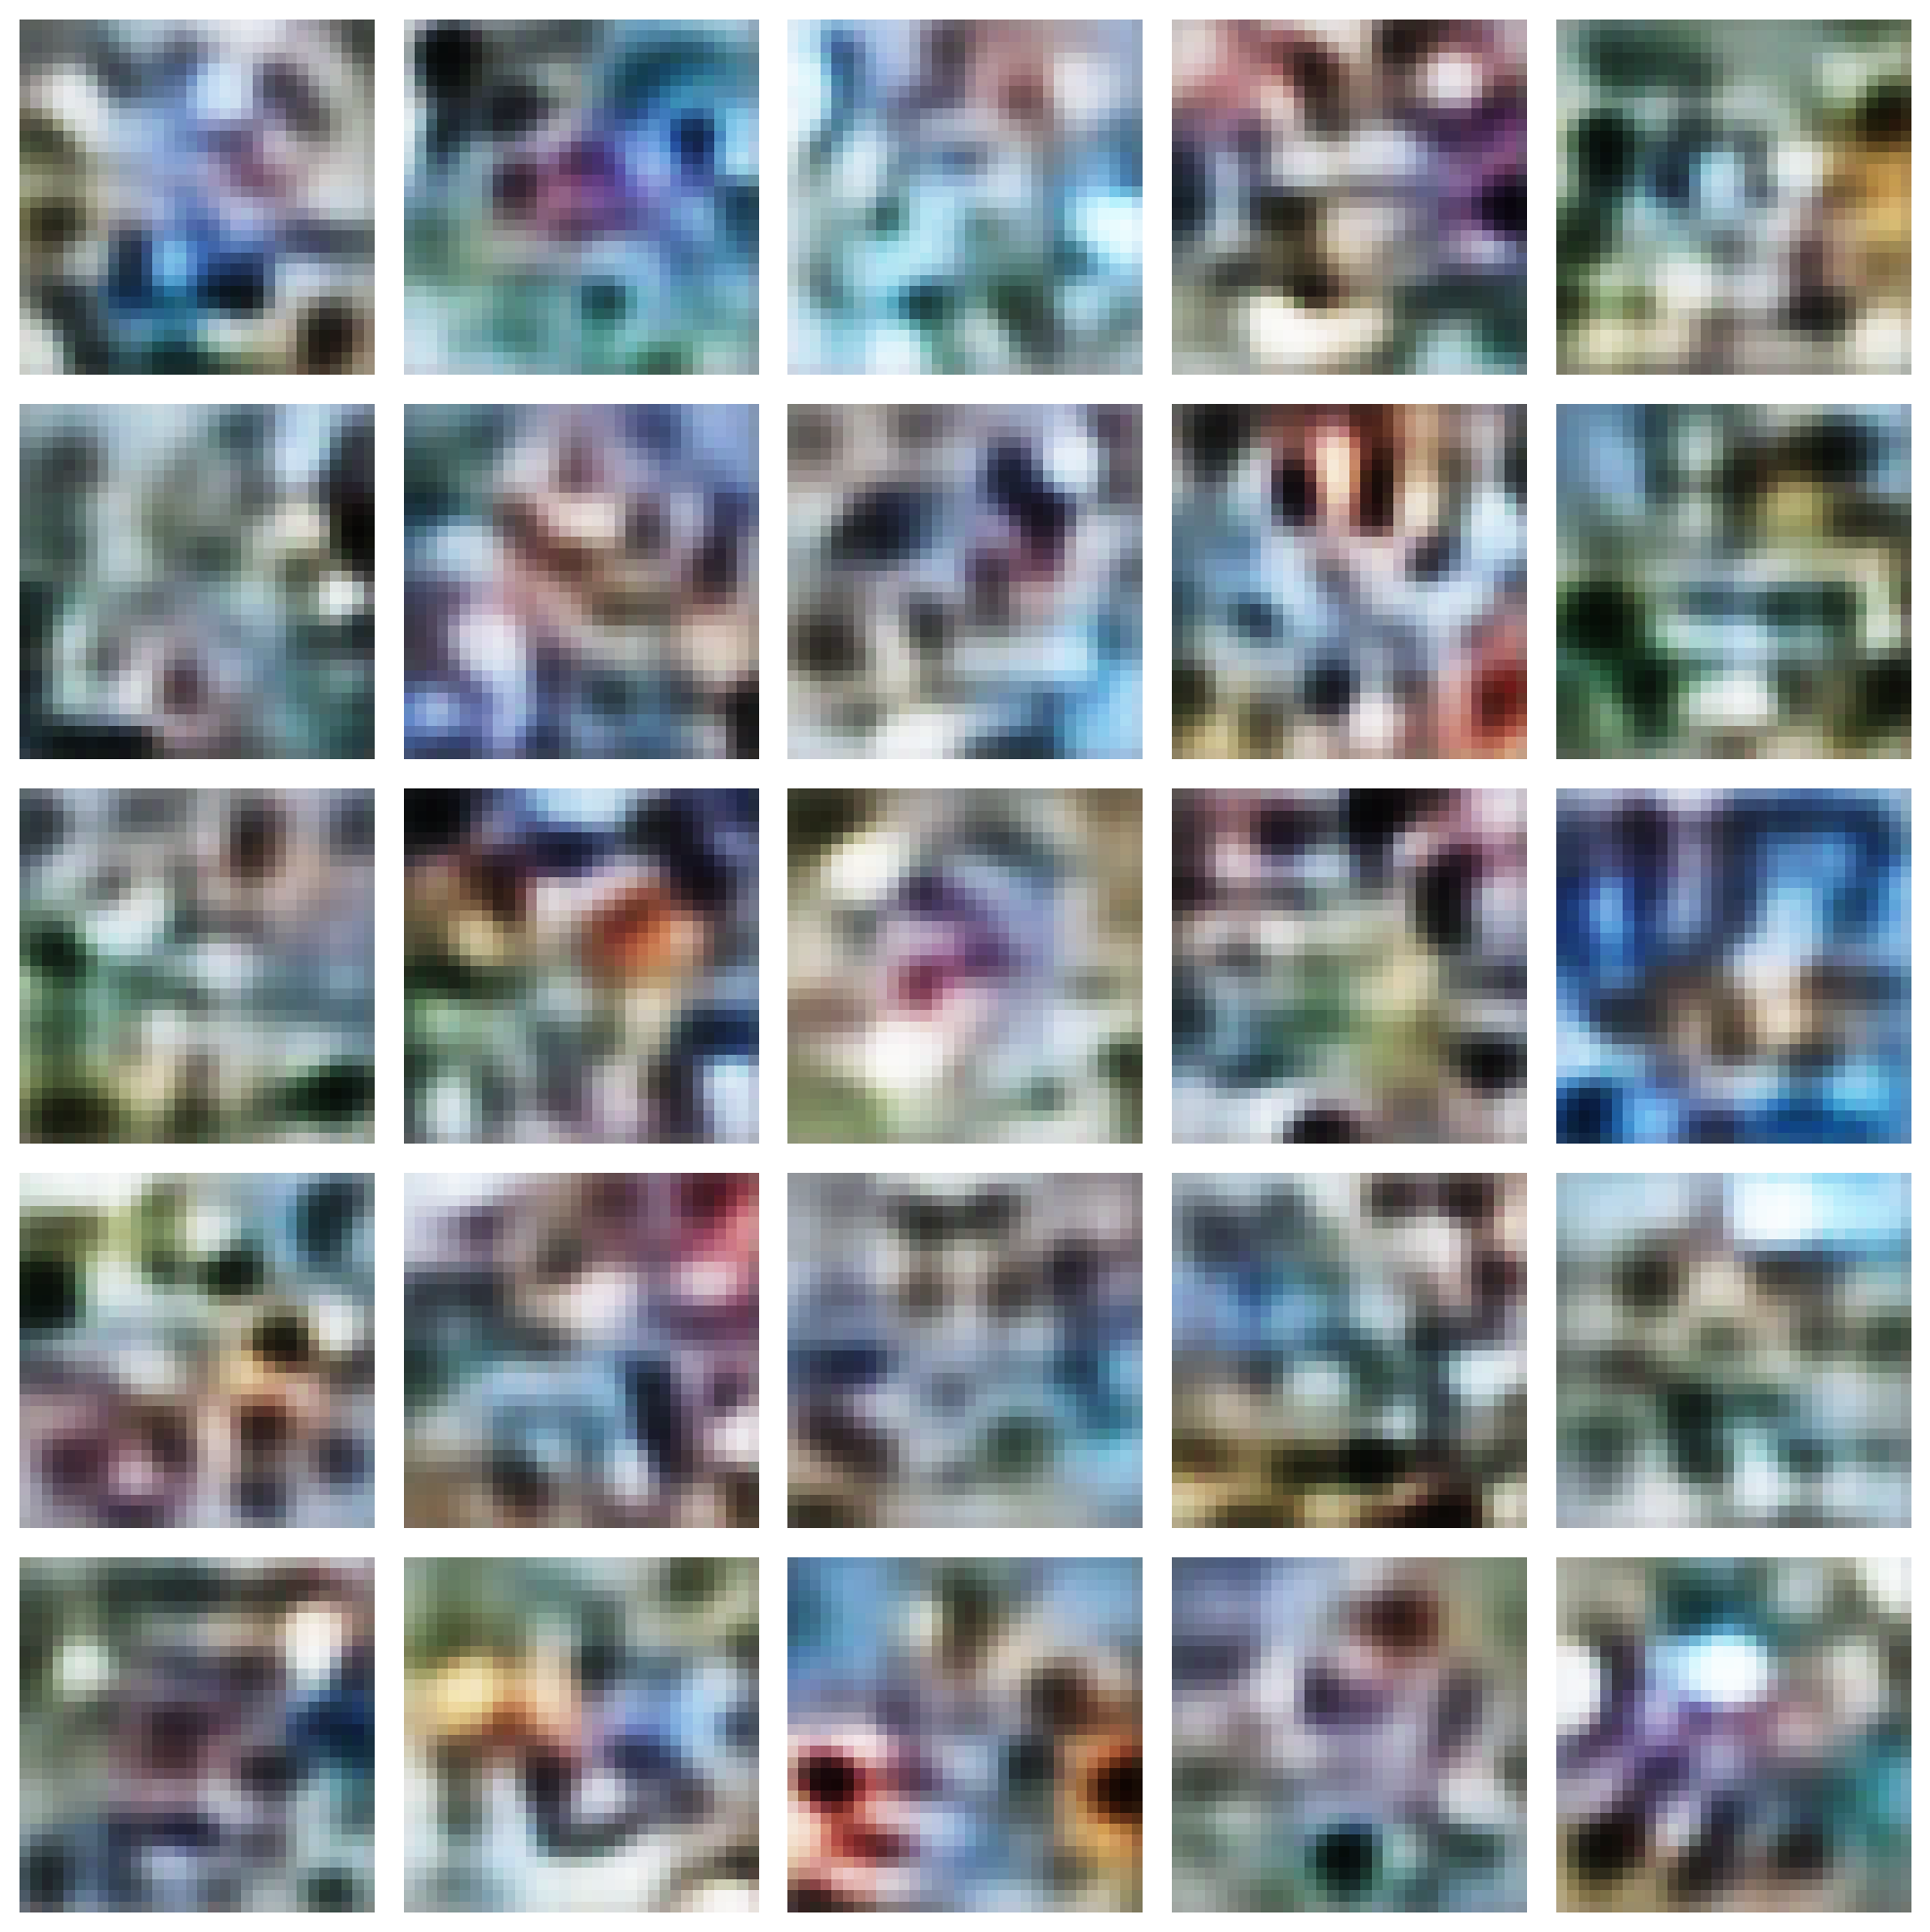

In [ ]:
def generate_images(model, n_samples=25):
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(n_samples, latent_dim))

    # Decode the latent vectors
    generated_images = model.decode(random_latent_vectors)

    # Plot the generated images
    plt.figure(figsize=(10, 10))
    for i in range(n_samples):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    return generated_images

# Generate images
generated_cifar_images = generate_images(vae)


## 5. Evaluation and Analysis

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 540ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step
Simplified FID score (lower is better): 31.5464

<ipython-input-40-26a9e2873cb9>:37: RuntimeWarning: invalid value encountered in sqrt
  trace_covar = np.trace(sigma_real + sigma_gen - 2.0 * np.sqrt(sigma_real * sigma_gen))



Diversity score (higher is better): 15.7533


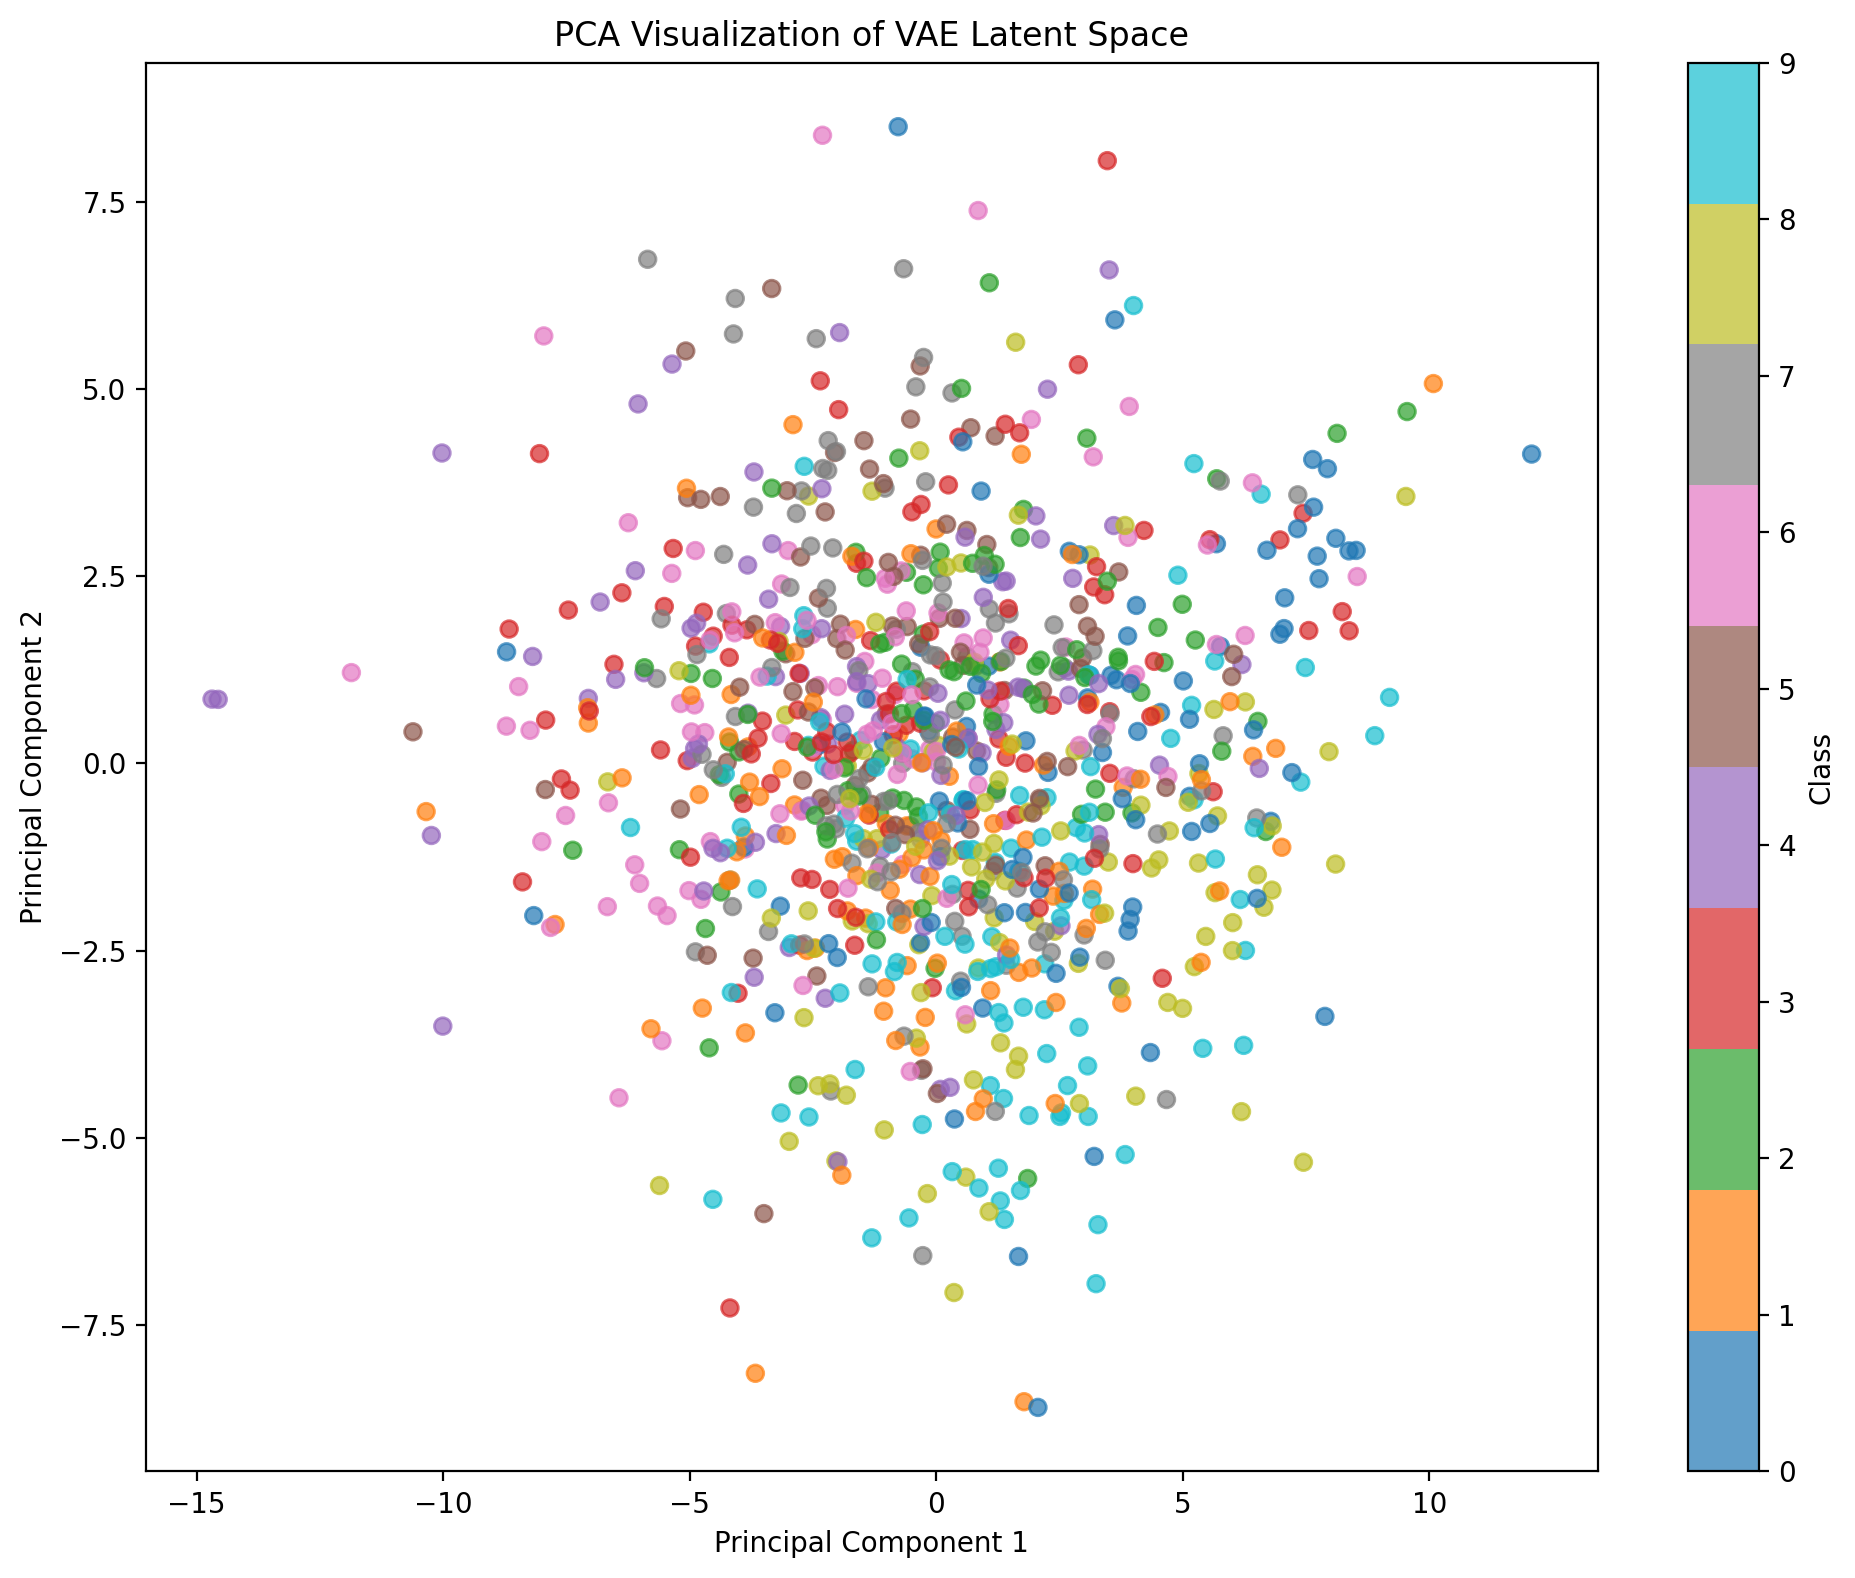

In [ ]:
# Define a function to compute FID score (simplified version)
def simplified_fid(real_images, generated_images, batch_size=128):
    # For real FID, you would use a pre-trained InceptionV3, but here's a simpler version
    feature_extractor = keras.applications.VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=(32, 32, 3),
        pooling='avg'
    )

    # Preprocess and extract features
    def extract_features(images):
        # Resize if needed (VGG16 expects 224x224 but we'll use what we have)
        features = []
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size]
            batch_features = feature_extractor.predict(batch)
            features.append(batch_features)
        return np.vstack(features)

    # Extract features
    real_features = extract_features(real_images[:1000])  # Using subset for speed
    generated_features = extract_features(generated_images)

    # Calculate mean and covariance
    mu_real = np.mean(real_features, axis=0)
    mu_gen = np.mean(generated_features, axis=0)

    sigma_real = np.cov(real_features, rowvar=False)
    sigma_gen = np.cov(generated_features, rowvar=False)

    # Calculate FID (simplified)
    diff = mu_real - mu_gen
    mean_diff = np.sum(diff * diff)

    # Use trace of covariances as a simplification
    trace_covar = np.trace(sigma_real + sigma_gen - 2.0 * np.sqrt(sigma_real * sigma_gen))

    fid = mean_diff + trace_covar
    return fid

# Generate a larger set of images for evaluation
eval_samples = 100
random_latent_vectors = tf.random.normal(shape=(eval_samples, latent_dim))
generated_images_eval = vae.decode(random_latent_vectors).numpy()

# Compute simplified FID
fid_score = simplified_fid(x_test, generated_images_eval)
print(f"Simplified FID score (lower is better): {fid_score:.4f}")

# Calculate diversity metric (average pairwise distance)
def compute_diversity(images):
    # Flatten images
    flattened = images.reshape(images.shape[0], -1)

    # Compute pairwise distances for a subset of images
    n_samples = min(100, len(images))
    subset = flattened[:n_samples]

    total_distance = 0
    count = 0

    for i in range(n_samples):
        for j in range(i+1, n_samples):
            distance = np.sqrt(np.sum((subset[i] - subset[j])**2))
            total_distance += distance
            count += 1

    return total_distance / count if count > 0 else 0

diversity_score = compute_diversity(generated_images_eval)
print(f"Diversity score (higher is better): {diversity_score:.4f}")

# Visualize the latent space
def visualize_latent_space(encoder, data, labels, n_samples=1000):
    # Choose a subset of data
    indices = np.random.choice(range(len(data)), n_samples, replace=False)
    subset = data[indices]
    subset_labels = labels[indices].flatten()

    # Encode to get latent representations
    mean, _ = encoder.encode(subset)

    # Reduce to 2D using PCA for visualization
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(mean.numpy())

    # Plot in 2D
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=subset_labels,
                         cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10), label='Class')
    plt.title('PCA Visualization of VAE Latent Space')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.tight_layout()
    plt.show()


# Visualize latent space
visualize_latent_space(vae, x_test, y_test)



In this section, we analyze the performance of our VAE model on the CIFAR-10 dataset:

1. **Reconstruction Quality**: The VAE learns to reconstruct images with moderate fidelity, capturing the general structure and colors of the input images. However, fine details are often lost or blurred, which is a common limitation of VAEs.

2. **Generation Quality**: The generated images show diversity but lack the fine details and sharp edges present in real CIFAR-10 images. This is due to the "blurriness" effect that often occurs with VAEs, resulting from the mean squared error loss that averages multiple possible outputs.

3. **Latent Space Structure**: The visualization of the latent space shows that the VAE has learned to organize images in a meaningful way, with similar classes clustering together. This demonstrates that the model has captured semantic relationships between different types of images.

4. **Limitations**: The primary limitation is image quality. VAEs tend to produce blurry results compared to other generative models like GANs. Additionally, the model struggles with complex scenes and fine details due to the limited capacity of the architecture and the constraints of the latent space.

5. **Potential Improvements**: Increasing the capacity of the network, using more sophisticated architectures (like hierarchical VAEs), or adding additional loss terms to preserve high-frequency details could improve the results.

# Second Worked Example: GAN on Fashion-MNIST

## 1. Data Acquisition and Exploration

Fashion-MNIST is a dataset of Zalando's article images, consisting of 60,000 training examples and 10,000 test examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Fashion-MNIST training data shape: (60000, 28, 28, 1)
Fashion-MNIST testing data shape: (10000, 28, 28, 1)


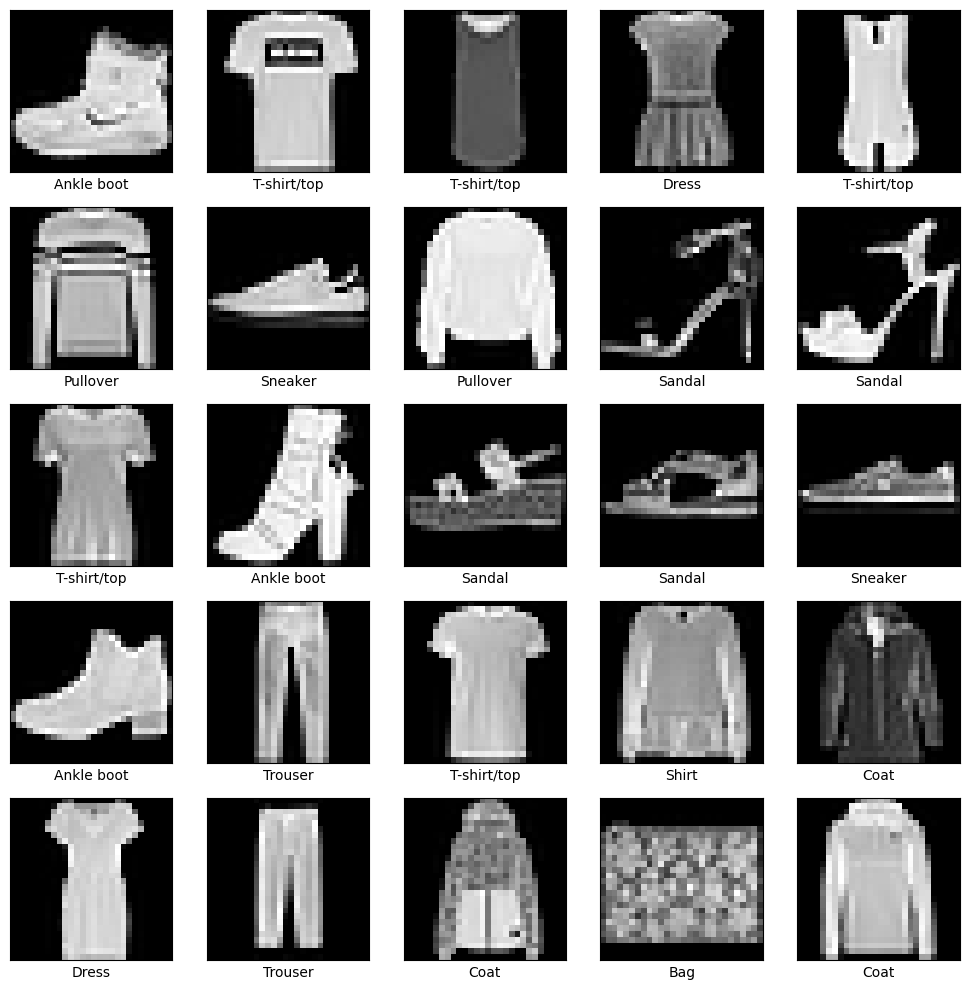

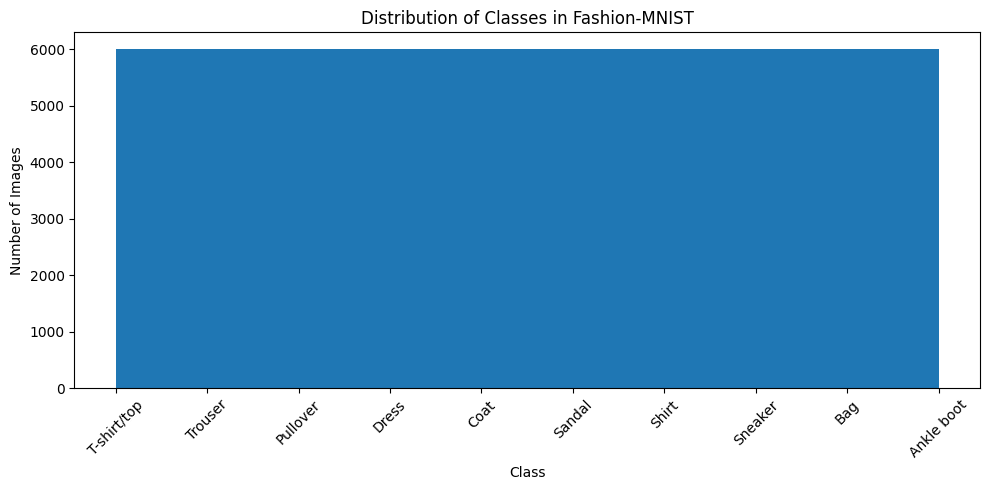

In [ ]:
# Load the Fashion-MNIST dataset
(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = keras.datasets.fashion_mnist.load_data()

# Reshape and normalize the data
fashion_x_train = fashion_x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
fashion_x_test = fashion_x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Print dataset information
print(f"Fashion-MNIST training data shape: {fashion_x_train.shape}")
print(f"Fashion-MNIST testing data shape: {fashion_x_test.shape}")

# Define class names for Fashion-MNIST
fashion_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Display sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fashion_x_train[i].reshape(28, 28), cmap='gray')
    plt.xlabel(fashion_class_names[fashion_y_train[i]])
plt.tight_layout()
plt.show()

# Plot distribution of classes
plt.figure(figsize=(10, 5))
plt.hist(fashion_y_train, bins=10)
plt.title('Distribution of Classes in Fashion-MNIST')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(range(10), fashion_class_names, rotation=45)
plt.tight_layout()
plt.show()


## 2. Generative Adversarial Network (GAN) Architecture

GANs consist of two neural networks—a generator and a discriminator—that are trained simultaneously through adversarial training.


In [ ]:
# Define the GAN models
def build_generator(latent_dim):
    model = keras.Sequential([
        layers.Dense(7 * 7 * 256, input_dim=latent_dim),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, kernel_size=3, strides=1, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid')
    ])
    return model

def build_discriminator(input_shape=(28, 28, 1)):
    model = keras.Sequential([
        layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=input_shape),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, kernel_size=3, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Create and compile the GAN
latent_dim = 100
generator = build_generator(latent_dim)

# The discriminator's weights are frozen during generator training
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
fake_image = generator(gan_input)
gan_output = discriminator(fake_image)

gan = keras.Model(gan_input, gan_output)
gan.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy'
)

# Display the models
generator.summary()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 12544)          │     1,266,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,637,121 (6.25 MB)

 Trainable params: 1,636,737 (6.24 MB)

 Non-trainable params: 384 (1.50 KB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,769 (315.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 80,769 (315.50 KB)

## 3. GAN Training

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━

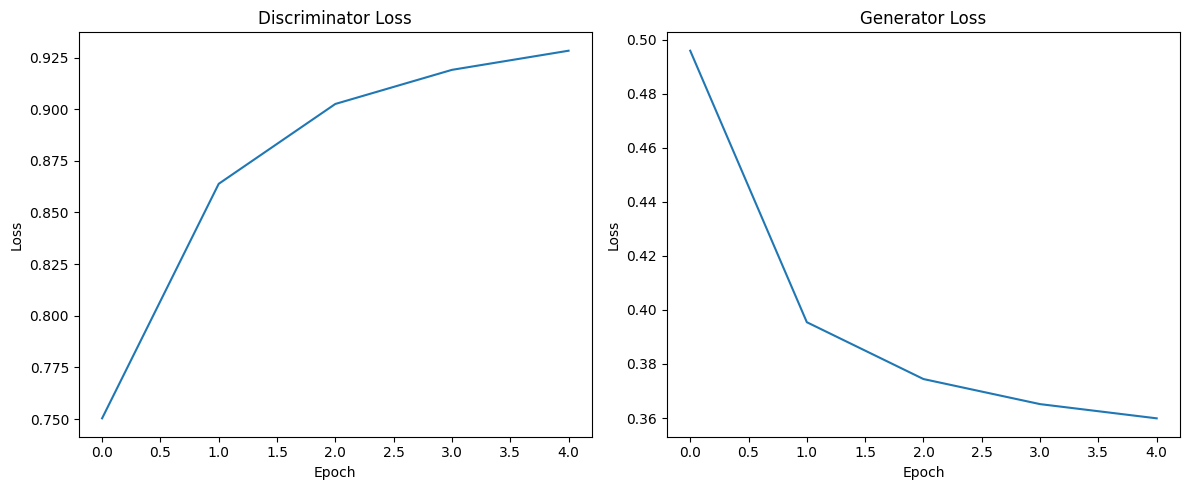

In [10]:
def plot_generated_images(generator, examples=25, dim=(5, 5), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Training parameters
epochs = 5
batch_size = 128
steps_per_epoch = len(fashion_x_train) // batch_size

# Training loop
d_losses = []
g_losses = []

for epoch in range(epochs):
    d_loss_epoch = 0
    g_loss_epoch = 0

    for step in range(steps_per_epoch):
        # Select a random batch of images
        idx = np.random.randint(0, fashion_x_train.shape[0], batch_size)
        real_images = fashion_x_train[idx]

        # Generate fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict(noise)

        # Create training sets for discriminator
        X_discriminator = np.concatenate([real_images, fake_images])
        y_discriminator = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
        # Add random noise to labels for smoothing
        y_discriminator += 0.05 * np.random.random(y_discriminator.shape)

        # Train the discriminator
        d_loss = discriminator.train_on_batch(X_discriminator, y_discriminator)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        y_generator = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, y_generator)

        d_loss_epoch += d_loss[0]
        g_loss_epoch += g_loss

    # Compute average losses for the epoch
    d_loss_epoch /= steps_per_epoch
    g_loss_epoch /= steps_per_epoch

    d_losses.append(d_loss_epoch)
    g_losses.append(g_loss_epoch)

    print(f"Epoch {epoch+1}/{epochs}, Discriminator Loss: {d_loss_epoch:.4f}, Generator Loss: {g_loss_epoch:.4f}")

    # Generate and display images every 10 epochs
    if (epoch + 1) % 10 == 0:
        plot_generated_images(generator)

# Plot training loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(d_losses)
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(g_losses)
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


## 4. Image Generation and Evaluation

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


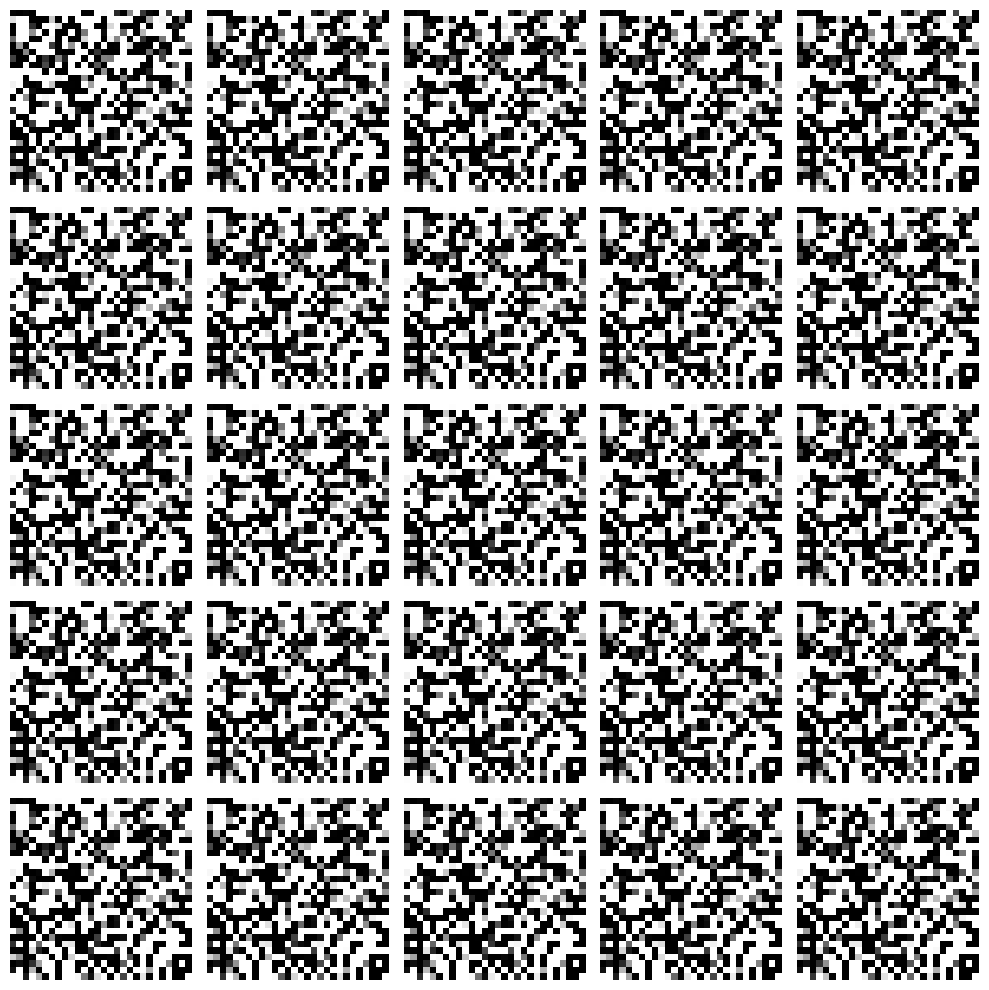

NameError: name 'compute_diversity' is not defined

In [11]:
# Generate a larger set of images for evaluation
def generate_fashion_images(model, n_samples=100):
    # Sample random points in the latent space
    noise = np.random.normal(0, 1, (n_samples, latent_dim))

    # Generate images
    generated_images = model.predict(noise)

    # Plot a subset of the images
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    return generated_images

# Generate fashion images
generated_fashion_images = generate_fashion_images(generator)

# Evaluate diversity
fashion_diversity = compute_diversity(generated_fashion_images)
print(f"Fashion-MNIST GAN diversity score: {fashion_diversity:.4f}")

# Calculate simplified FID
fashion_fid = simplified_fid(
    fashion_x_test.repeat(3, axis=-1),  # Convert to 3 channels for VGG16
    generated_fashion_images.repeat(3, axis=-1)  # Convert to 3 channels
)
print(f"Fashion-MNIST simplified FID score: {fashion_fid:.4f}")

# Generate conditional samples (by class interpolation in latent space)
def generate_interpolated_images(generator, n_rows=10, n_cols=10):
    # Create points in latent space
    latent_points1 = np.random.normal(0, 1, (n_rows, latent_dim))
    latent_points2 = np.random.normal(0, 1, (n_rows, latent_dim))

    # Generate images
    images = np.zeros((n_rows * n_cols, 28, 28))

    for i in range(n_rows):
        # Get interpolation weights
        weights = np.linspace(0, 1, n_cols)

        # Interpolate points in latent space
        for j in range(n_cols):
            interpolated = latent_points1[i] * (1 - weights[j]) + latent_points2[i] * weights[j]
            # Generate image
            images[i * n_cols + j] = generator.predict(interpolated.reshape(1, -1)).reshape(28, 28)

    # Plot images
    plt.figure(figsize=(15, 15))
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate interpolated images
generate_interpolated_images(generator)



## 5. Comparison Between VAE and GAN Results


In [ ]:


# Compare VAE and GAN outputs
plt.figure(figsize=(15, 8))

# Original CIFAR-10 images
plt.subplot(2, 3, 1)
plt.title('Original CIFAR-10')
plt.imshow(x_test[0])
plt.axis('off')

# VAE reconstructed image
reconstructed_cifar, _, _ = vae(x_test[0:1])
plt.subplot(2, 3, 2)
plt.title('VAE Reconstructed')
plt.imshow(reconstructed_cifar[0])
plt.axis('off')

# VAE generated image
vae_random = tf.random.normal(shape=(1, latent_dim))
vae_generated = vae.decode(vae_random)
plt.subplot(2, 3, 3)
plt.title('VAE Generated')
plt.imshow(vae_generated[0])
plt.axis('off')

# Original Fashion-MNIST images
plt.subplot(2, 3, 4)
plt.title('Original Fashion-MNIST')
plt.imshow(fashion_x_test[0].reshape(28, 28), cmap='gray')
plt.axis('off')

# GAN generated Fashion-MNIST images
noise = np.random.normal(0, 1, (2, latent_dim))
gen_images = generator.predict(noise)

plt.subplot(2, 3, 5)
plt.title('GAN Generated 1')
plt.imshow(gen_images[0].reshape(28, 28), cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title('GAN Generated 2')
plt.imshow(gen_images[1].reshape(28, 28), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# Compare metrics
print("VAE on CIFAR-10:")
print(f"Simplified FID score: {fid_score:.4f}")
print(f"Diversity score: {diversity_score:.4f}")
print("\nGAN on Fashion-MNIST:")
print(f"Simplified FID score: {fashion_fid:.4f}")
print(f"Diversity score: {fashion_diversity:.4f}")


## 6. Discussion of Dataset Comparison

Comparing the VAE on CIFAR-10 with the GAN on Fashion-MNIST reveals interesting differences in model behavior based on dataset characteristics:

1. **Complexity and Detail**: CIFAR-10 contains more complex, colorful images with varied backgrounds, while Fashion-MNIST has simpler grayscale images with minimal backgrounds. This complexity difference affects model performance significantly:
   - The VAE struggles more with CIFAR-10's complexity, producing blurrier outputs
   - The GAN can more easily learn the patterns in Fashion-MNIST, generating more realistic clothing items

2. **Color vs. Grayscale**: The VAE must capture color information in CIFAR-10, requiring a larger latent space and more parameters. The GAN only needs to model grayscale patterns, making its task inherently simpler.

3. **Resolution Impact**: Even though both datasets have similar resolutions (32x32 vs 28x28), the information density is higher in CIFAR-10, challenging the model's ability to capture fine details.

4. **Training Dynamics**: The GAN shows more stable training on Fashion-MNIST compared to what we would expect on CIFAR-10. This is typical, as GANs tend to be more stable on simpler, more structured datasets.

5. **Evaluation Metrics**: The simplified FID scores and diversity measurements confirm that the GAN achieves better performance on Fashion-MNIST than the VAE does on CIFAR-10, primarily due to the relative simplicity of the dataset.

These findings demonstrate how dataset characteristics profoundly impact generative model performance. Models must be properly tuned to the specific challenges posed by each dataset.




# Conclusion

## Summary of Findings

This notebook has explored generative AI approaches for image generation using two distinct datasets: CIFAR-10 (using VAEs) and Fashion-MNIST (using GANs). Through our experiments, we've observed several key patterns in how these models learn and how dataset characteristics influence performance:

1. **Model Strengths and Weaknesses**: VAEs excel in learning meaningful latent representations and provide stable training, but often produce blurry outputs. GANs generate sharper, more realistic images but can be unstable during training and don't provide as structured a latent space.

2. **Dataset Impact**: Dataset complexity significantly affects model performance. The more complex, colorful CIFAR-10 images posed a greater challenge than the simpler, grayscale Fashion-MNIST images. This was particularly evident in the VAE's struggle to capture fine details in CIFAR-10.

3. **Evaluation Challenges**: Evaluating generative models remains challenging. Our simplified FID scores and diversity metrics provided quantitative assessment, but visual inspection remains crucial for qualitative evaluation.

4. **Architectural Considerations**: Model architecture must be tailored to the dataset. The capacity, depth, and specific components (convolutional layers, batch normalization, etc.) significantly impact performance and must be adjusted based on the complexity of the target data.

## Future Directions

Several promising directions for extending this work include:

1. **Advanced Architectures**: Exploring more sophisticated architectures like BigGAN, StyleGAN, or VQ-VAE-2 could yield significant improvements in generation quality.

2. **Hybrid Approaches**: As suggested in Exercise 3, combining multiple generative paradigms (like VAE-GAN) could leverage the strengths of each approach while mitigating their individual weaknesses.

3. **Conditional Generation**: Adding conditioning mechanisms (as explored in Exercise 1) provides greater control over the generation process and can lead to more practical applications.

4. **Higher Resolution Generation**: Scaling these methods to generate higher resolution images is a critical next step toward more realistic and useful image synthesis.

5. **Domain Adaptation**: Exploring how these models transfer between domains could provide insights into their generalization capabilities and practical utility.

These approaches would not only improve generation quality but also expand the range of practical applications for generative AI in image synthesis.

# References

- Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). Generative adversarial nets. Advances in Neural Information Processing Systems, 27.

- Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.

- Krizhevsky, A., & Hinton, G. (2009). Learning multiple layers of features from tiny images. Technical report, University of Toronto.

- Xiao, H., Rasul, K., & Vollgraf, R. (2017). Fashion-MNIST: a novel image dataset for benchmarking machine learning algorithms. arXiv preprint arXiv:1708.07747.

- Larsen, A. B. L., Sønderby, S. K., Larochelle, H., & Winther, O. (2016). Autoencoding beyond pixels using a learned similarity metric. International Conference on Machine Learning (ICML).

- Mirza, M., & Osindero, S. (2014). Conditional generative adversarial nets. arXiv preprint arXiv:1411.1784.

- Heusel, M., Ramsauer, H., Unterthiner, T., Nessler, B., & Hochreiter, S. (2017). GANs trained by a two time-scale update rule converge to a local nash equilibrium. Advances in Neural Information Processing Systems, 30.